In [14]:
import random
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning & modeling 
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import joblib

In [15]:
# Clustering & Inspection of Enriched Dataset

df_final = pd.read_csv("email_priority_final_v2.csv")
print("Loaded dataset:", df_final.shape)
print(df_final['priority_label'].value_counts())

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=10000,
    ngram_range=(1, 2),
    min_df=3
)
X = vectorizer.fit_transform(df_final['text'])
print("TF-IDF matrix:", X.shape)

# Dimensionality Reduction
svd = TruncatedSVD(n_components=150, random_state=42)
X_reduced = svd.fit_transform(X)

# Clustering 
# Use 3 clusters since our goal is Prioritize / Default / Slow
kmeans = KMeans(n_clusters=4, random_state=42)
df_final['cluster'] = kmeans.fit_predict(X_reduced)

# Inspect clusters 
feature_names = np.array(vectorizer.get_feature_names_out())

for c in sorted(df_final['cluster'].unique()):
    print(f"\n\nCLUSTER {c} — Top Terms")
    print("-"*80)
    order = kmeans.cluster_centers_[c].argsort()[::-1][:20]
    print(", ".join(feature_names[order]))
    
    print(f"\nCLUSTER {c} — 20 Sample Messages")
    print("-"*80)
    sample = df_final[df_final['cluster'] == c].sample(min(20, len(df_final[df_final['cluster'] == c])), random_state=42)
    for i, msg in enumerate(sample['text'].values, 1):
        clean_msg = re.sub(r'\s+', ' ', msg.strip())
        print(f"{i}. {clean_msg[:400]}{'...' if len(clean_msg) > 400 else ''}\n")


Loaded dataset: (10300, 2)
priority_label
Prioritize    4685
Default       2847
Slow          2768
Name: count, dtype: int64
TF-IDF matrix: (10300, 772)


CLUSTER 0 — Top Terms
--------------------------------------------------------------------------------
10 minutes, 10 value, 10, 10 good, 10 attached, 10 ready, 10 conference, accounts department, 6789 items, 519942, alpha attached, 6789, account, account temporarily, act limited, account compromised, 90, 12345 delayed, 519942 expires, activity link

CLUSTER 0 — 20 Sample Messages
--------------------------------------------------------------------------------
1. Act Now: Limited Time Offer - 90% Off All Products! Make thousands of dollars from home with our proven system. No experience required. Sign up today: [link]

2. URGENT: Your Account Has Been Compromised! Urgent security notification! A login from an unrecognized device was detected. Review activity: [link]

3. Team Stand-up at 10 AM Here's your weekly dose of news and updat

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


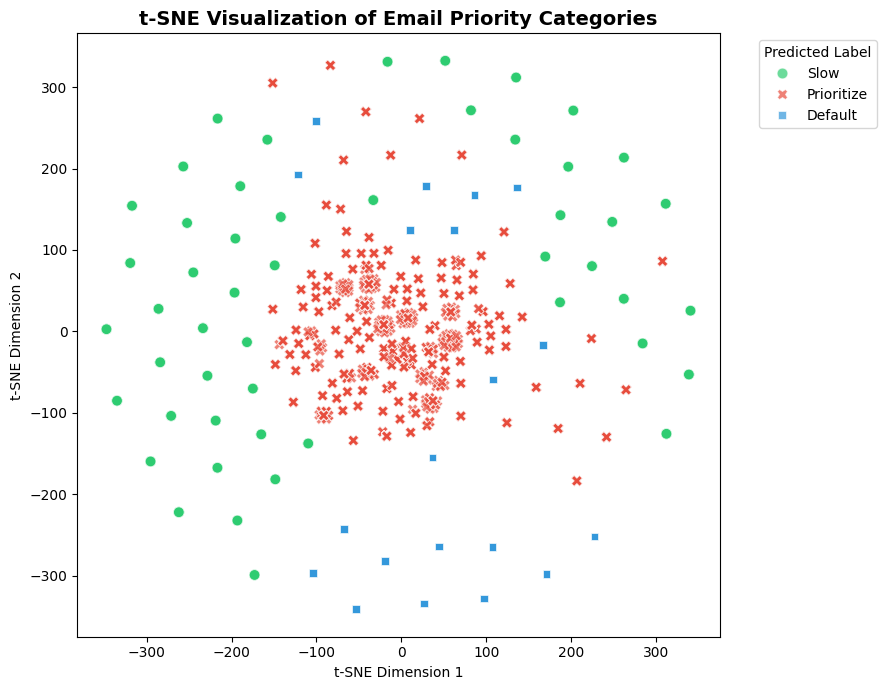


 Cluster–Label Alignment (% of each true label falling into each semantic cluster):
predicted_label  Default  Prioritize  Slow
priority_label                            
Default              0.3        0.11  0.60
Prioritize           0.0        0.55  0.45
Slow                 0.3        0.38  0.32


 PREDICTED LABEL: Slow — 4326 samples total
--------------------------------------------------------------------------------
1. Photos from the Weekend Trip Good morning, everyone. Just a quick reminder for our daily stand-up meeting at 10 AM. Please be ready to share your progress and any blockers. Thanks, Project Manager

2. Invoice for Services Rendered Good morning, everyone. Just a quick reminder for our daily stand-up meeting at 10 AM. Please be ready to share your progress and any blockers. Thanks, Project Manager

3. Catching Up - How are you? We value your feedback! Please take a few moments to complete a short survey about your recent purchase from us. Your input helps us improve

In [16]:
# Visualize clusters with semantic labels (t-SNE)

# Reduce for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=40, n_iter=1500)
tsne_coords = tsne.fit_transform(X_reduced)

df_final['x'] = tsne_coords[:, 0]
df_final['y'] = tsne_coords[:, 1]

# Map clusters to human-readable labels before plotting 
cluster_map = {
    0: "Prioritize",   # urgent / transactional / security
    1: "Default",      # conversational / system updates
    2: "Slow"          # newsletters, feedback, non-urgent
}
df_final['predicted_label'] = df_final['cluster'].map(cluster_map)

# Plot with proper semantic colors 
plt.figure(figsize=(9,7))
sns.scatterplot(
    data=df_final,
    x='x', y='y',
    hue='predicted_label',  # semantic labels
    style='predicted_label',
    palette={
        "Prioritize": "#E74C3C",  # red for urgency
        "Default": "#3498DB",     # blue for neutral
        "Slow": "#2ECC71"         # green for calm
    },
    alpha=0.7,
    s=60
)
plt.title("t-SNE Visualization of Email Priority Categories", fontsize=14, weight='bold')
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Predicted Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Check alignment between true & predicted labels 
alignment = pd.crosstab(df_final['priority_label'], df_final['predicted_label'], normalize='index')
print("\n Cluster–Label Alignment (% of each true label falling into each semantic cluster):")
print(alignment.round(2))

# Print sample messages by predicted label for qualitative sanity check 
import re

for lbl in df_final['predicted_label'].unique():
    subset = df_final[df_final['predicted_label'] == lbl]
    print(f"\n\n PREDICTED LABEL: {lbl} — {len(subset)} samples total")
    print("-" * 80)
    for i, msg in enumerate(subset.sample(min(10, len(subset)), random_state=42)['text'], 1):
        clean_msg = re.sub(r'\s+', ' ', msg.strip())
        print(f"{i}. {clean_msg[:400]}{'...' if len(clean_msg) > 400 else ''}\n")

# Save final mapped dataset 
# df_final.to_csv("email_priority_clustered_mapped.csv", index=False)

Loaded columns: ['text', 'priority_label', 'cluster', 'x', 'y', 'predicted_label']

Dataset size: 10300
priority_label
Prioritize    4685
Default       2847
Slow          2768
Name: count, dtype: int64 

Encoding text embeddings... (takes ~1–2 min depending on size)

 Classification Report:
               precision    recall  f1-score   support

     Default       1.00      1.00      1.00       569
  Prioritize       0.99      1.00      1.00       937
        Slow       1.00      0.99      0.99       554

    accuracy                           1.00      2060
   macro avg       1.00      1.00      1.00      2060
weighted avg       1.00      1.00      1.00      2060



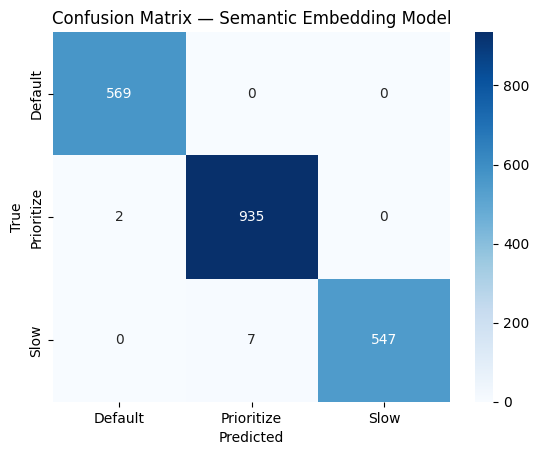


🔍 Inference on final model examples:

Your password reset code is 742981 and expires in 10 minutes.
{'label': 'Prioritize', 'confidence': 0.9881608269331139, 'probs': {'Default': np.float64(0.001061121293692982), 'Prioritize': np.float64(0.9881608269331139), 'Slow': np.float64(0.01077805177319302)}}
----------------------------------------------------------------------
Monthly newsletter: new product releases and insights.
{'label': 'Slow', 'confidence': 0.4600419479895426, 'probs': {'Default': np.float64(0.10391000101674436), 'Prioritize': np.float64(0.4360480509937131), 'Slow': np.float64(0.4600419479895426)}}
----------------------------------------------------------------------
Meeting summary attached. No action required.
{'label': 'Prioritize', 'confidence': 0.4455840277734886, 'probs': {'Default': np.float64(0.3759075089087654), 'Prioritize': np.float64(0.4455840277734886), 'Slow': np.float64(0.17850846331774592)}}
---------------------------------------------------------------

In [17]:
# Final Iteration — Semantic Embedding Classifier (Clean Version for Known Columns)

df = pd.read_csv("email_priority_clustered_mapped.csv")
print("Loaded columns:", df.columns.tolist())

# Explicitly assign column names based on known schema
text_col = 'text'
label_col = 'priority_label'

# Clean text
df[text_col] = df[text_col].fillna('').astype(str).str.strip()

print(f"\nDataset size: {len(df)}")
print(df[label_col].value_counts(), "\n")

# Train/test split 
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df[label_col]
)

# Encode text using SentenceTransformer embeddings 
print("Encoding text embeddings... (takes ~1–2 min depending on size)")
embedder = SentenceTransformer("all-MiniLM-L6-v2")

X_train = embedder.encode(train_df[text_col].tolist(), normalize_embeddings=True)
X_test = embedder.encode(test_df[text_col].tolist(), normalize_embeddings=True)

y_train = train_df[label_col]
y_test = test_df[label_col]

# Train logistic regression model
model = LogisticRegression(max_iter=400, class_weight='balanced')
model.fit(X_train, y_train)

# Evaluate performance
y_pred = model.predict(X_test)
print("\n Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix — Semantic Embedding Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Inference helper function
def explain_email(text):
    vec = embedder.encode([text], normalize_embeddings=True)
    probs = model.predict_proba(vec)[0]
    idx = np.argmax(probs)
    return {
        'label': model.classes_[idx],
        'confidence': float(probs[idx]),
        'probs': dict(zip(model.classes_, probs))
    }

# Example inference tests
examples = [
    "Your password reset code is 742981 and expires in 10 minutes.",
    "Monthly newsletter: new product releases and insights.",
    "Meeting summary attached. No action required.",
    "Account login detected from Chrome on Windows.",
    "Product update: version 2.3 release notes attached.",
    "Please see attached project timeline draft.",
    "We noticed unusual activity in your account. Verify immediately.",
    "Community digest: upcoming webinars and feature news."
]

print("\n🔍 Inference on final model examples:\n")
for s in examples:
    print(s)
    print(explain_email(s))
    print('-'*70)


In [18]:
# Reload Email Priority Classifier (with reasoning)

# --- Load artifacts ---
artifacts = joblib.load("model_artifacts/email_priority_model.joblib")
model = artifacts["model"]
classes = artifacts["classes"] 

# --- Load same sentence-transformer ---
embedder = SentenceTransformer("all-MiniLM-L6-v2")

# --- Lightweight keyword lexicon for reasoning ---
reasoning_terms = {
    "Prioritize": ["security", "verify", "account", "code", "login", "alert", "expires", "activity", "immediately"],
    "Slow": ["newsletter", "update", "sale", "community", "feedback", "blog", "event", "promotion", "digest"],
    "Default": ["meeting", "attached", "project", "invoice", "report", "schedule", "document", "reminder"]
}

def explain_email(text):
    vec = embedder.encode([text], normalize_embeddings=True)
    probs = model.predict_proba(vec)[0]
    idx = int(np.argmax(probs))
    label = classes[idx]
    confidence = float(probs[idx])

    reasoning = reasoning_terms.get(label, [])[:5]
    return {
        "label": label,
        "confidence": round(confidence, 3),
        "reasoning": reasoning
        #"probs": {cls: float(p) for cls, p in zip(classes, probs)}
    }

# --- Example usage ---
if __name__ == "__main__":
    sample = "Your verification code is 482019 — enter it within 5 minutes to continue."
    print(explain_email(sample))



{'label': 'Prioritize', 'confidence': 0.963, 'reasoning': ['security', 'verify', 'account', 'code', 'login']}


In [19]:
slow_examples = [
    "Spring collection is here — explore our latest arrivals and enjoy 20% off this weekend.",
    "Don't miss our monthly newsletter with design tips, case studies, and product news.",
    "Join our community webinar: 'How to get the most out of your subscription.'",
    "Celebrate with us! Anniversary sale starts today with special discounts for members.",
    "Read our new blog post on productivity trends and remote work insights.",
    "Reminder: limited-time offer ends soon — upgrade to premium for 50% off.",
    "Get inspired! Check out customer stories and behind-the-scenes updates in our digest.",
    "Weekly update: new integrations, product improvements, and community highlights.",
    "Your exclusive coupon: SAVE15 — valid through Sunday only.",
    "We're launching something big! Sign up to be first to know when it drops."
]

for s in slow_examples:
    print(s)
    print(explain_email(s))
    print('-'*70)


Spring collection is here — explore our latest arrivals and enjoy 20% off this weekend.
{'label': 'Slow', 'confidence': 0.652, 'reasoning': ['newsletter', 'update', 'sale', 'community', 'feedback']}
----------------------------------------------------------------------
Don't miss our monthly newsletter with design tips, case studies, and product news.
{'label': 'Slow', 'confidence': 0.958, 'reasoning': ['newsletter', 'update', 'sale', 'community', 'feedback']}
----------------------------------------------------------------------
Join our community webinar: 'How to get the most out of your subscription.'
{'label': 'Prioritize', 'confidence': 0.9, 'reasoning': ['security', 'verify', 'account', 'code', 'login']}
----------------------------------------------------------------------
Celebrate with us! Anniversary sale starts today with special discounts for members.
{'label': 'Slow', 'confidence': 0.687, 'reasoning': ['newsletter', 'update', 'sale', 'community', 'feedback']}
-------------

In [13]:
#  Generate validation dataset for Streamlit visualization

# Predict on test split used in your training
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)
confidence = np.max(probs, axis=1)

# Build new dataframe for app
df_val = pd.DataFrame({
    "text": test_df[text_col],
    "true_label": y_test.values,
    "predicted_label": y_pred,
    "confidence": confidence
})

# Optional: show report for sanity
print("\nTrue Model Evaluation Report:\n", classification_report(y_test, y_pred))

# Save file for Streamlit
#df_val.to_csv("model_artifacts/validation_results.csv", index=False)




📊 True Model Evaluation Report:
               precision    recall  f1-score   support

     Default       1.00      1.00      1.00       569
  Prioritize       0.99      1.00      1.00       937
        Slow       1.00      0.99      0.99       554

    accuracy                           1.00      2060
   macro avg       1.00      1.00      1.00      2060
weighted avg       1.00      1.00      1.00      2060

